In [9]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns  
from PIL import Image  
import cv2  
import tensorflow as tf 
from tensorflow.keras import layers, models 
from tensorflow.keras.applications import InceptionV3  
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.model_selection import train_test_split  
from tensorflow.keras.utils import to_categorical 
from tqdm import tqdm

import warnings  




## Loading the dataset::

In [10]:
import os

base_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset"
print("Top-level folders:")
print(os.listdir(base_path))


Top-level folders:
['DFD_original sequences', 'DFD_manipulated_sequences']


In [11]:
REAL_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
FAKE_PATH = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"


In [12]:
# If videos are nested inside subfolders
real_videos = []
for root, dirs, files in os.walk(REAL_PATH):
    for file in files:
        if file.endswith(".mp4"):
            real_videos.append(os.path.join(root, file))


In [13]:
import os
import cv2
from tqdm import tqdm
import numpy as np

# Constants
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10  # Frames per video
MAX_VIDEOS = 200 

# Dataset paths
REAL_PATH = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences'
FAKE_PATH = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences'

# Verify dataset availability
if not os.path.exists(REAL_PATH) or not os.path.exists(FAKE_PATH):
    raise FileNotFoundError("Dataset paths not found")

# Load OpenCV's built-in face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_frames_with_faces(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < frame_count:
        cap.release()
        return []

    step = total_frames // frame_count
    frames = []

    for i in range(0, total_frames, step):
        if len(frames) >= frame_count:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, output_size)
            frames.append(face)

    cap.release()
    return frames

# Prepare dataset arrays
data = []
labels = []

# Process real videos
real_videos = [f for f in os.listdir(REAL_PATH) if f.endswith('.mp4')][:MAX_VIDEOS]
print("Processing real videos...")
for video_file in tqdm(real_videos):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames_with_faces(video_path)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(0)  # Real

# Process fake videos
fake_videos = [f for f in os.listdir(FAKE_PATH) if f.endswith('.mp4')][:MAX_VIDEOS]
print("Processing fake videos...")
for video_file in tqdm(fake_videos):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames_with_faces(video_path)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(1)  # Fake

# Convert to numpy arrays
data = np.array(data)  # Shape: (samples, 10, 128, 128, 3)
labels = np.array(labels)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Processing real videos...


100%|██████████| 200/200 [18:13<00:00,  5.47s/it]


Processing fake videos...


100%|██████████| 200/200 [17:32<00:00,  5.26s/it]

Data shape: (235, 10, 128, 128, 3)
Labels shape: (235,)


In [14]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Data shapes: Train - {X_train.shape}, Val - {X_val.shape}, Test - {X_test.shape}")

# Save to avoid recomputing
np.save('/kaggle/working/X_train.npy', X_train)
np.save('/kaggle/working/y_train.npy', y_train)
np.save('/kaggle/working/X_val.npy', X_val)
np.save('/kaggle/working/y_val.npy', y_val)
np.save('/kaggle/working/X_test.npy', X_test)
np.save('/kaggle/working/y_test.npy', y_test)

Data shapes: Train - (164, 10, 128, 128, 3), Val - (35, 10, 128, 128, 3), Test - (36, 10, 128, 128, 3)


## DATA AUGMENTATION:

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    shear_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    channel_shift_range=10.0,
    fill_mode='nearest'
)

def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = datagen.random_transform(frame)
        augmented_frames.append(frame)
    return np.array(augmented_frames)

augmented_data = []
augmented_labels = []

for i in tqdm(range(len(X_train))):
    augmented_frames = augment_frames(X_train[i])
    augmented_data.append(augmented_frames)
    augmented_labels.append(y_train[i])

X_train_augmented = np.concatenate((X_train, np.array(augmented_data)))
y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)))

print(f"Augmented Train Data: {X_train_augmented.shape}")
np.save('/kaggle/working/X_train_augmented.npy', X_train_augmented)
np.save('/kaggle/working/y_train_augmented.npy', y_train_augmented)

100%|██████████| 164/164 [00:07<00:00, 22.79it/s]


Augmented Train Data: (328, 10, 128, 128, 3)


## Model ARCHITECTURE 

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, TimeDistributed, Bidirectional, GRU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

FRAME_COUNT = 10  # Set here or pass explicitly

def build_best_model(input_shape=(FRAME_COUNT, 128, 128, 3)):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-30]:  # Unfreeze last 30 layers for fine-tuning
        layer.trainable = False

    model = Sequential([
        TimeDistributed(base_model, input_shape=input_shape),
        TimeDistributed(GlobalAveragePooling2D()),
        BatchNormalization(),
        Bidirectional(GRU(128, return_sequences=False, kernel_regularizer=l2(0.005))),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_best_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, 10, 4, 4, 2048)      │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 10, 2048)            │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │       1,672,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,559,210 (86.06 MB)

 Trainable params: 10,633,858 (40.56 MB)

 Non-trainable params: 11,925,352 (45.49 MB)

## MODEL TRAINING:

In [19]:
# Model Training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight

# Compute class weights for balance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Place ModelCheckpoint here
checkpoint = ModelCheckpoint(
    "/kaggle/working/deepfake_detection_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=50,  # Reduced for testing, adjust to 100 if needed
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, lr_scheduler, early_stopping]
)

# Place model.save() here
model.save("/kaggle/working/deepfake_detection_model_final.keras")

# Verify saved files
!ls -lh /kaggle/working/

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5310 - loss: 8.2336
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /kaggle/working/deepfake_detection_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 92s 595ms/step - accuracy: 0.5299 - loss: 8.2335 - val_accuracy: 0.6000 - val_loss: 7.4894 - learning_rate: 1.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4945 - loss: 7.8729
Epoch 2: val_accuracy improved from 0.60000 to 0.65714, saving model to /kaggle/working/deepfake_detection_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.4948 - loss: 7.8739 - val_accuracy: 0.6571 - val_loss: 7.4020 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5333 - loss: 7.9004
Epoch 3: val_accuracy improved from 0.65714 to 0.68571, saving model to /kaggle/working/deepfake_detection_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.5337 - loss: 7.8960 - val_accuracy: 0.68

## MODEL TESTING:


2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 14s/step
Test Accuracy: 69.44%
Classification Report:
              precision    recall  f1-score   support

        REAL       0.64      0.50      0.56        14
        FAKE       0.72      0.82      0.77        22

    accuracy                           0.69        36
   macro avg       0.68      0.66      0.66        36
weighted avg       0.69      0.69      0.69        36



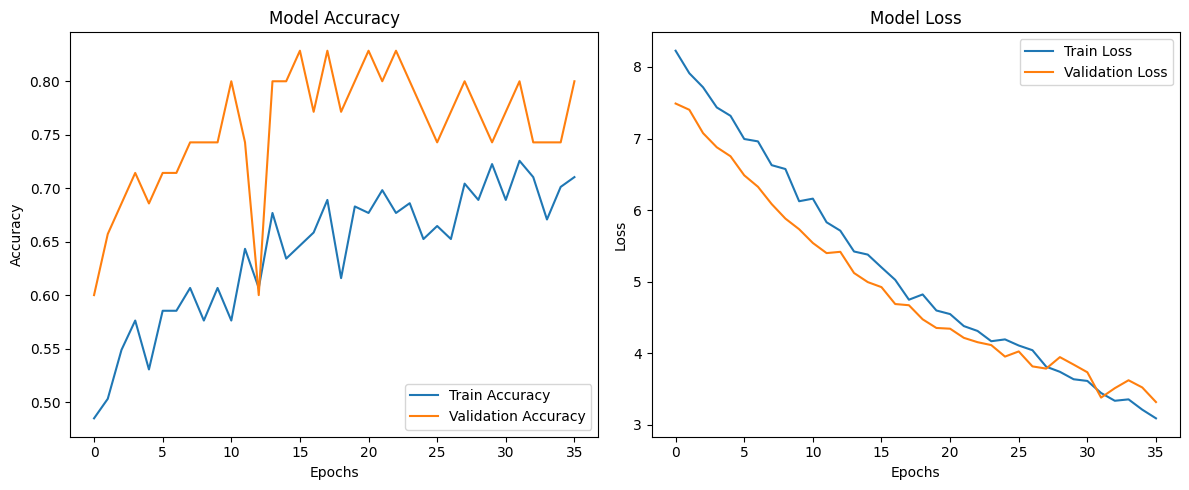

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


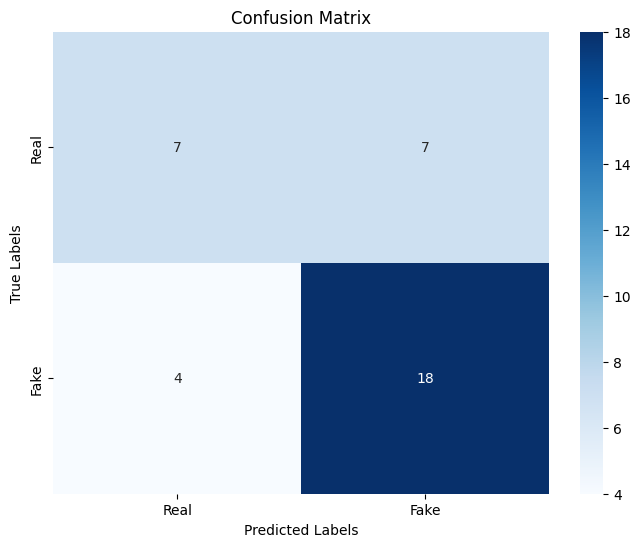

              precision    recall  f1-score   support

        Real       0.64      0.50      0.56        14
        Fake       0.72      0.82      0.77        22

    accuracy                           0.69        36
   macro avg       0.68      0.66      0.66        36
weighted avg       0.69      0.69      0.69        36



In [20]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = load_model('/kaggle/working/deepfake_detection_model.keras')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['REAL', 'FAKE']))

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_labels = ['Real', 'Fake']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    print(classification_report(y_true, y_pred_classes, target_names=cm_labels))

plot_training_history(history)
plot_confusion_matrix(model, X_test, y_test)

## Real Time detection:

In [22]:
# Real-Time Detection
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Function to extract frames from a video
def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return np.array([])  # Return empty array if video fails to open
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)  # Resize frame
        frames.append(frame)
    cap.release()
    
    # Convert to NumPy array and ensure 4D shape
    if len(frames) == 0:
        print(f"Warning: No frames extracted from {video_path}")
        return np.zeros((0, output_size[0], output_size[1], 3), dtype=np.uint8)
    return np.array(frames, dtype=np.uint8)

# Function to predict video
def predict_video(video_path, model, output_size=(128, 128), frame_count=10):
    frames = extract_frames(video_path, output_size, frame_count)
    if len(frames) == 0:
        print(f"Error: No frames to predict for {video_path}")
        return
    
    # Ensure frames is 4D
    if len(frames.shape) == 3:  # (height, width, channels)
        frames = np.expand_dims(frames, axis=0)  # Make it (1, height, width, channels)
    elif len(frames.shape) == 4 and frames.shape[0] < frame_count:
        pad_length = frame_count - frames.shape[0]
        pad_width = [(0, pad_length)] + [(0, 0) for _ in range(len(frames.shape) - 1)]
        frames = np.pad(frames, pad_width, mode='constant', constant_values=0)
    elif len(frames.shape) != 4:
        print(f"Error: Unexpected frame shape {frames.shape} for {video_path}")
        return

    frames = frames / 255.0  # Normalize
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    prediction = model.predict(frames)
    label = "FAKE" if np.argmax(prediction) == 1 else "REAL"
    confidence = float(prediction[0][np.argmax(prediction)])
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")

# Load the model with file existence check
model_path = '/kaggle/working/deepfake_detection_model.keras'
if os.path.exists(model_path):
    loaded_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
else:
    print(f"Error: Model file not found at {model_path}. Please run the training section first.")
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Use the same dataset paths as data loading
REAL_PATH = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences'
FAKE_PATH = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences'


# Get the first available video files (verify they exist)
real_videos = os.listdir(REAL_PATH)
fake_videos = os.listdir(FAKE_PATH)
if not real_videos or not fake_videos:
    print("Error: No video files found in REAL_PATH or FAKE_PATH. Check dataset input.")
else:
    real_sample_path = os.path.join(REAL_PATH, real_videos[0])  # First real video
    fake_sample_path = os.path.join(FAKE_PATH, fake_videos[0])  # First fake video

    # Test predictions
    print("Real Video Prediction:")
    predict_video(real_sample_path, loaded_model)

    print("Fake Video Prediction:")
    predict_video(fake_sample_path, loaded_model)

# List contents of /kaggle/working/ to verify model or other files
!ls -lh /kaggle/working/

Model loaded successfully from /kaggle/working/deepfake_detection_model.keras
Real Video Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Prediction: REAL (Confidence: 0.88)
Fake Video Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction: REAL (Confidence: 0.98)
total 2.4G
-rw-r--r-- 1 root root 168M Jul  5 01:56 deepfake_detection_model_final.keras
-rw-r--r-- 1 root root 168M Jul  5 01:53 deepfake_detection_model.keras
-rw-r--r-- 1 root root 136M Jul  5 01:45 X_test.npy
-rw-r--r-- 1 root root 1.3G Jul  5 01:46 X_train_augmented.npy
-rw-r--r-- 1 root root 616M Jul  5 01:45 X_train.npy
-rw-r--r-- 1 root root 132M Jul  5 01:45 X_val.npy
-rw-r--r-- 1 root root  704 Jul  5 01:45 y_test.npy
-rw-r--r-- 1 root root 5.3K Jul  5 01:46 y_train_augmented.npy
-rw-r--r-- 1 root root 2.7K Jul  5 01:45 y_train.npy
-rw-r--r-- 1 root root  688 Jul  5 01:45 y_val.npy


In [1]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
from IPython.display import Video, display

# Constants
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10
OUTPUT_VIDEO_PATH = "/kaggle/working/labeled_output.mp4"

# Load the trained model
model_path = '/kaggle/working/deepfake_detection_model.keras'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")
model = load_model(model_path)
print("Model loaded.")

def extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return np.array([])

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)

    frames = []
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)
    cap.release()

    if len(frames) < frame_count:
        black_frame = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
        frames.extend([black_frame] * (frame_count - len(frames)))

    return np.array(frames)

def predict_video(video_path, model):
    frames = extract_frames(video_path)
    if len(frames) == 0:
        return None, None

    frames = frames / 255.0
    frames = np.expand_dims(frames, axis=0)  # (1, frame_count, 128, 128, 3)
    prediction = model.predict(frames)
    label_idx = np.argmax(prediction)
    label = "FAKE" if label_idx == 1 else "REAL"
    confidence = float(prediction[0][label_idx])
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    return label, confidence

def save_video_with_label(video_path, label, confidence, output_path=OUTPUT_VIDEO_PATH):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video {video_path}")
        return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    text = f"{label} ({confidence*100:.1f}%)"
    color = (0, 255, 0) if label == "REAL" else (0, 0, 255)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, color, 2, cv2.LINE_AA)
        out.write(frame)

    cap.release()
    out.release()
    print(f"Annotated video saved to {output_path}")

# Test on a video
test_video_path = '/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__exit_phone_room__YVGY8LOK.mp4'

label, confidence = predict_video(test_video_path, model)
if label:
    save_video_with_label(test_video_path, label, confidence)
    display(Video(OUTPUT_VIDEO_PATH, embed=True, width=640, height=480))


2025-07-05 02:09:11.584987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751681351.608210    2926 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751681351.615162    2926 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751681355.229581    2926 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model loaded.


I0000 00:00:1751681374.239139    2959 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Prediction: FAKE (Confidence: 0.99)
Annotated video saved to /kaggle/working/labeled_output.mp4
